In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install imutils
!pip install imageio
import os
from collections import Counter
import matplotlib.pyplot as plt
from imutils import contours
from skimage import io
import numpy as np
import imutils
import cv2
import re

import warnings

In [3]:
%cd drive/My Drive/Documentary at KMUTT/year 4/CPE463 Image processing/Project

/content/drive/My Drive/Documentary at KMUTT/year 4/CPE463 Image processing/Project


#### Load dataset



In [0]:
# We have 2 datasets which is word and sentence 
image_path = "Images/dataset/sentence"
def loadImages(path):
    image_files = sorted([os.path.join(path, file)
                          for file in os.listdir(path)
                          if file.endswith('.jpg')])
    return image_files

In [0]:
images = loadImages(image_path)

In [0]:
# sort image name by ascending
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [0]:
images.sort(key=natural_keys)

In [8]:
images

['Images/dataset/sentence/image1.jpg',
 'Images/dataset/sentence/image2.jpg',
 'Images/dataset/sentence/image3.jpg',
 'Images/dataset/sentence/image4.jpg',
 'Images/dataset/sentence/image5.jpg',
 'Images/dataset/sentence/image6.jpg',
 'Images/dataset/sentence/image7.jpg',
 'Images/dataset/sentence/image8.jpg',
 'Images/dataset/sentence/image9.jpg',
 'Images/dataset/sentence/image10.jpg',
 'Images/dataset/sentence/image11.jpg',
 'Images/dataset/sentence/image12.jpg',
 'Images/dataset/sentence/image13.jpg',
 'Images/dataset/sentence/image14.jpg',
 'Images/dataset/sentence/image15.jpg',
 'Images/dataset/sentence/image16.jpg',
 'Images/dataset/sentence/image17.jpg',
 'Images/dataset/sentence/image18.jpg',
 'Images/dataset/sentence/image19.jpg',
 'Images/dataset/sentence/image20.jpg',
 'Images/dataset/sentence/image21.jpg',
 'Images/dataset/sentence/image22.jpg']

#### Read image

In [0]:
def read_image(image_name):
  image = io.imread(image_name)
  plt.imshow(image)
  return image

#### Image enhancement

In [0]:
def convertToGray(image):
  # Since this image is RGB, we will convert to grayscale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # apply Otsu's thresholding method to binarize the image
  thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
  kernel = np.ones((5,5), np.uint8)
  return thresh, kernel

In [0]:
def image_enhancement(image):
  data = image.copy()
  thresh, kernel = convertToGray(data)
  # erode and dilate to remove some of the unnecessary detail
  thresh = cv2.erode(thresh, kernel, iterations = 0)
  thresh = cv2.dilate(thresh, kernel, iterations = 0)
  plt.imshow(thresh)
  return thresh

#### Get edges and contours of image

In [0]:
def get_contours(thresh):
  # Get contours in the thresholded image
  # RETR_EXTERNAL only external contours will be kept (no circles inside other circles)
  # CHAIN_APPROX_SIMPLE contour is simplified by reducing the number of points
    
  contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # This will return the set of outline
  contours = imutils.grab_contours(contours) 
  return contours

In [0]:
def get_edges():
  # Remove noise by apply gaussian filter
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  # Get egdes 
  # Apply Canny Edge Detection
  edged = cv2.Canny(blurred, 75, 200)
  plt.imshow(edges)
  return edges

#### Getting diameter of black circle

In [0]:
def get_diameter(contours):
  # This will return in term x,y,w,h
  boundingBoxes = [list(cv2.boundingRect(c)) for c in contours]
  print("Bounding boxes: " + str(boundingBoxes))
    
  c = Counter([i[2] for i in boundingBoxes])

  mode = c.most_common(1)[0][0]
  if mode > 1:
    diameter = mode
  else:
    diameter = c.most_common(2)[1][0]
  return diameter

We have to store all circles that contours found by selecting only circle that had width fell within a certain range of the determined diameter and had a ratio of height to width close to 1. It could also be verified that the majority of the pixels inside the contour are black to prevent selecting “empty” dots

#### Getting bounding box of black dots

In [0]:
def get_boundingBoxes(contours, image):
  diameter = get_diameter(contours)

  circles = []
  for c in contours:
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = w / float(h)
    if diameter*0.8 <= w <= diameter*1.2 and 0.8 <= ratio <= 1.2:
      circles.append(c)   

  BB = [list(cv2.boundingRect(c)) for c in circles]
   # list of sorted contours and bounding boxes
  (circle, boundingBox) = zip(*sorted(zip(contours, BB), key = lambda b: b[1][1]*len(image) + b[1][0]))

  return boundingBox

#### Translate image to text

black dot we can find by bounding box position if position exist then we mask this position to 1s'

In [0]:
def draw_contour(image, contours, boundingBoxes):
  from google.colab.patches import cv2_imshow
  data = image.copy()
  color = (0, 255, 0)
  i = 0  
  for q in range(len(contours)):
    cv2.drawContours(data, contours[q], -1, color, 3)
    cv2.putText(data, str(i), (boundingBoxes[q][0] + boundingBoxes[q][2]//2, boundingBoxes[q][1] + boundingBoxes[q][3]//2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    i += 1
  # show the image
  cv2_imshow(image)
  cv2.waitKey(0)

get letters

In [0]:
# mask position of black dots with 1s'
def mask_dots(letters,x,y):
  if x == 1:
    if y == 1:
      letters[0] = 1
    elif y == 41:
      letters[2] = 1
    else:
      letters[4] = 1
  elif x == 41:
    if y == 1:
      letters[1] = 1
    elif y == 41:
      letters[3] = 1
    else:
      letters[5] = 1

In [0]:
def get_letters(boundingBoxes):
  # create a list to store position of black dots
  letters = []
  for r in range(6):
    letters.append(0)
    continue
  print("List of letters: " + str(letters))

  minYD = 42
  Bxs = list(boundingBoxes)
  Bxs.append((100000, 0))

  dots = [[]]

  # Get dots from postion of bounding boxes
  for b in range(len(Bxs)-1):
    # if in column 1 (• ○) 
    if Bxs[b][0] < Bxs[b+1][0]:      
        dots[-1].append((b, Bxs[b][0:2]))        
        print("Column 1: " + str(Bxs[b][0:2]))
        mask_dots(letters,Bxs[b][0], Bxs[b][1])    
    
    # if in column 2 (○ •) 
    else:
      dots[-1].append((b, Bxs[b][0:2]))
      print("Column 2: " + str(Bxs[b][0:2]))
      mask_dots(letters,Bxs[b][0], Bxs[b][1])  

      # if difference height between 2 dots is 
      if abs(Bxs[b+1][1] - Bxs[b][1]) > minYD:  
        if len(dots)%3 == 0 and not dots[-1]:
          dots.append([])

  for d in dots: 
    print(d)
    
  return letters

In [0]:
def braille_dictionary():
  # create dictionary of black dots position
  characters = {'A': '1', 'B': '13', 'C': '12', 'D': '124', 'E': '14', 'F': '123',
            'G': '1234', 'H': '134', 'I': '23', 'J': '234', 'K': '15',
            'L': '135', 'M': '125', 'N': '1245', 'O': '145', 'P': '1235',
            'Q': '12345', 'R': '1345', 'S': '235', 'T': '2345', 'U': '156',
            'V': '1356', 'W': '2346', 'X': '1256', 'Y': '12456', 'Z': '1456',
          '#': '2456'}
  nums = {'A': '1', 'B': '2', 'C': '3', 'D': '4', 'E': '5', 'F': '6', 'G': '7', 'H': '8', 'I': '9', 'J': '0'}
  return characters, nums

In [0]:
def translate(letters):
  characters, nums = braille_dictionary()

  braille = {v: k for k, v in characters.items()}
  letters = np.array([np.array(l) for l in letters])

  ans  = ''
  f = letters.flatten()
  f = ''.join([str(i + 1) for i,d in enumerate(f) if d == 1])
  print("Black dots position: " + str(f))
  if f in braille.keys():
    ans += braille[f]
  else:
    ans += ' '
  
  print("Translated: " + str(ans))
  return ans

## Translate

#### Braille translation function

In [0]:
def braille_translate(path):
  image = read_image(path)
  thresh = image_enhancement(image)
  contours = get_contours(thresh)
  boundingBoxes = get_boundingBoxes(contours, image)
  draw_contour(image, contours, boundingBoxes)
  letters = get_letters(boundingBoxes)
  letter = translate(letters)
  return letter

#### Test with dataset

In [0]:
# replace numbers
def replace_nums(key, ans):
    character, nums = braille_dictionary()
    num =  nums.get(key)
    ans = re.sub('#(?P<key>[a-zA-Z])', num, ans)

    return ans

Bounding boxes: [[1, 41, 26, 26], [41, 1, 26, 26]]


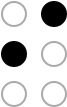

List of letters: [0, 0, 0, 0, 0, 0]
Column 2: [41, 1]
Column 1: [1, 41]
[(0, [41, 1]), (1, [1, 41])]
Black dots position: 23
Translated: I
Bounding boxes: [[41, 81, 26, 26], [1, 81, 26, 26], [41, 41, 26, 26], [1, 41, 26, 26], [41, 1, 26, 26], [1, 1, 26, 26]]


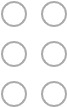

List of letters: [0, 0, 0, 0, 0, 0]
Column 1: [1, 1]
Column 2: [41, 1]
Column 1: [1, 41]
Column 2: [41, 41]
Column 1: [1, 81]
Column 1: [41, 81]
[(0, [1, 1]), (1, [41, 1]), (2, [1, 41]), (3, [41, 41]), (4, [1, 81]), (5, [41, 81])]
Black dots position: 123456
Translated:  
Bounding boxes: [[41, 41, 26, 26], [1, 41, 26, 26], [1, 1, 26, 26]]


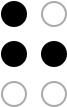

List of letters: [0, 0, 0, 0, 0, 0]
Column 2: [1, 1]
Column 1: [1, 41]
Column 1: [41, 41]
[(0, [1, 1]), (1, [1, 41]), (2, [41, 41])]
Black dots position: 134
Translated: H
Bounding boxes: [[1, 1, 26, 26]]


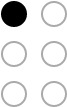

List of letters: [0, 0, 0, 0, 0, 0]
Column 1: [1, 1]
[(0, [1, 1])]
Black dots position: 1
Translated: A
Bounding boxes: [[41, 81, 26, 26], [1, 81, 26, 26], [1, 41, 26, 26], [1, 1, 26, 26]]


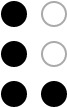

List of letters: [0, 0, 0, 0, 0, 0]
Column 2: [1, 1]
Column 2: [1, 41]
Column 1: [1, 81]
Column 1: [41, 81]
[(0, [1, 1]), (1, [1, 41]), (2, [1, 81]), (3, [41, 81])]
Black dots position: 1356
Translated: V
Bounding boxes: [[41, 41, 26, 26], [1, 1, 26, 26]]


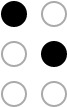

List of letters: [0, 0, 0, 0, 0, 0]
Column 1: [1, 1]
Column 1: [41, 41]
[(0, [1, 1]), (1, [41, 41])]
Black dots position: 14
Translated: E
Bounding boxes: [[41, 81, 26, 26], [1, 81, 26, 26], [41, 41, 26, 26], [1, 41, 26, 26], [41, 1, 26, 26], [1, 1, 26, 26]]


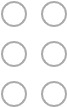

List of letters: [0, 0, 0, 0, 0, 0]
Column 1: [1, 1]
Column 2: [41, 1]
Column 1: [1, 41]
Column 2: [41, 41]
Column 1: [1, 81]
Column 1: [41, 81]
[(0, [1, 1]), (1, [41, 1]), (2, [1, 41]), (3, [41, 41]), (4, [1, 81]), (5, [41, 81])]
Black dots position: 123456
Translated:  
Bounding boxes: [[41, 81, 26, 26], [1, 81, 26, 26], [41, 41, 26, 26], [41, 1, 26, 26]]


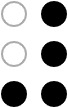

List of letters: [0, 0, 0, 0, 0, 0]
Column 2: [41, 1]
Column 2: [41, 41]
Column 1: [1, 81]
Column 1: [41, 81]
[(0, [41, 1]), (1, [41, 41]), (2, [1, 81]), (3, [41, 81])]
Black dots position: 2456
Translated: #
Bounding boxes: [[1, 41, 26, 26], [1, 1, 26, 26]]


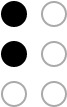

List of letters: [0, 0, 0, 0, 0, 0]
Column 2: [1, 1]
Column 1: [1, 41]
[(0, [1, 1]), (1, [1, 41])]
Black dots position: 13
Translated: B
Bounding boxes: [[41, 81, 26, 26], [1, 81, 26, 26], [41, 41, 26, 26], [1, 41, 26, 26], [41, 1, 26, 26], [1, 1, 26, 26]]


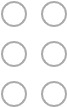

List of letters: [0, 0, 0, 0, 0, 0]
Column 1: [1, 1]
Column 2: [41, 1]
Column 1: [1, 41]
Column 2: [41, 41]
Column 1: [1, 81]
Column 1: [41, 81]
[(0, [1, 1]), (1, [41, 1]), (2, [1, 41]), (3, [41, 41]), (4, [1, 81]), (5, [41, 81])]
Black dots position: 123456
Translated:  
Bounding boxes: [[41, 1, 26, 26], [1, 1, 26, 26]]


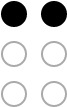

List of letters: [0, 0, 0, 0, 0, 0]
Column 1: [1, 1]
Column 1: [41, 1]
[(0, [1, 1]), (1, [41, 1])]
Black dots position: 12
Translated: C
Bounding boxes: [[1, 1, 26, 26]]


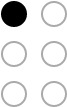

List of letters: [0, 0, 0, 0, 0, 0]
Column 1: [1, 1]
[(0, [1, 1])]
Black dots position: 1
Translated: A
Bounding boxes: [[1, 81, 26, 26], [41, 41, 26, 26], [1, 41, 26, 26], [41, 1, 26, 26]]


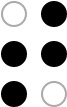

List of letters: [0, 0, 0, 0, 0, 0]
Column 2: [41, 1]
Column 1: [1, 41]
Column 2: [41, 41]
Column 1: [1, 81]
[(0, [41, 1]), (1, [1, 41]), (2, [41, 41]), (3, [1, 81])]
Black dots position: 2345
Translated: T
Bounding boxes: [[1, 81, 26, 26], [1, 41, 26, 26], [41, 1, 26, 26]]


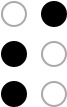

List of letters: [0, 0, 0, 0, 0, 0]
Column 2: [41, 1]
Column 2: [1, 41]
Column 1: [1, 81]
[(0, [41, 1]), (1, [1, 41]), (2, [1, 81])]
Black dots position: 235
Translated: S
Bounding boxes: [[41, 81, 26, 26], [1, 81, 26, 26], [41, 41, 26, 26], [1, 41, 26, 26], [41, 1, 26, 26], [1, 1, 26, 26]]


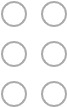

List of letters: [0, 0, 0, 0, 0, 0]
Column 1: [1, 1]
Column 2: [41, 1]
Column 1: [1, 41]
Column 2: [41, 41]
Column 1: [1, 81]
Column 1: [41, 81]
[(0, [1, 1]), (1, [41, 1]), (2, [1, 41]), (3, [41, 41]), (4, [1, 81]), (5, [41, 81])]
Black dots position: 123456
Translated:  
Bounding boxes: [[1, 1, 26, 26]]


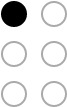

List of letters: [0, 0, 0, 0, 0, 0]
Column 1: [1, 1]
[(0, [1, 1])]
Black dots position: 1
Translated: A
Bounding boxes: [[1, 81, 26, 26], [41, 41, 26, 26], [1, 41, 26, 26], [41, 1, 26, 26]]


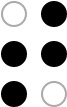

List of letters: [0, 0, 0, 0, 0, 0]
Column 2: [41, 1]
Column 1: [1, 41]
Column 2: [41, 41]
Column 1: [1, 81]
[(0, [41, 1]), (1, [1, 41]), (2, [41, 41]), (3, [1, 81])]
Black dots position: 2345
Translated: T
Bounding boxes: [[41, 81, 26, 26], [1, 81, 26, 26], [41, 41, 26, 26], [1, 41, 26, 26], [41, 1, 26, 26], [1, 1, 26, 26]]


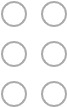

List of letters: [0, 0, 0, 0, 0, 0]
Column 1: [1, 1]
Column 2: [41, 1]
Column 1: [1, 41]
Column 2: [41, 41]
Column 1: [1, 81]
Column 1: [41, 81]
[(0, [1, 1]), (1, [41, 1]), (2, [1, 41]), (3, [41, 41]), (4, [1, 81]), (5, [41, 81])]
Black dots position: 123456
Translated:  
Bounding boxes: [[41, 41, 26, 26], [1, 41, 26, 26], [1, 1, 26, 26]]


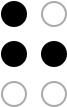

List of letters: [0, 0, 0, 0, 0, 0]
Column 2: [1, 1]
Column 1: [1, 41]
Column 1: [41, 41]
[(0, [1, 1]), (1, [1, 41]), (2, [41, 41])]
Black dots position: 134
Translated: H
Bounding boxes: [[1, 81, 26, 26], [41, 41, 26, 26], [1, 1, 26, 26]]


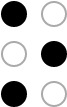

List of letters: [0, 0, 0, 0, 0, 0]
Column 1: [1, 1]
Column 2: [41, 41]
Column 1: [1, 81]
[(0, [1, 1]), (1, [41, 41]), (2, [1, 81])]
Black dots position: 145
Translated: O
Bounding boxes: [[1, 81, 26, 26], [41, 1, 26, 26], [1, 1, 26, 26]]


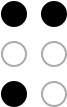

List of letters: [0, 0, 0, 0, 0, 0]
Column 1: [1, 1]
Column 2: [41, 1]
Column 1: [1, 81]
[(0, [1, 1]), (1, [41, 1]), (2, [1, 81])]
Black dots position: 125
Translated: M
Bounding boxes: [[41, 41, 26, 26], [1, 1, 26, 26]]


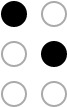

List of letters: [0, 0, 0, 0, 0, 0]
Column 1: [1, 1]
Column 1: [41, 41]
[(0, [1, 1]), (1, [41, 41])]
Black dots position: 14
Translated: E


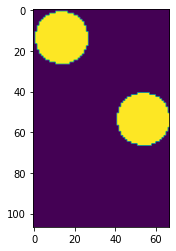

In [23]:
translated = ''
for i in range(0, len(images)):

  # save previous letter
  if translated == '':
    prevLetter = ''
  else:
    prevLetter = translated[-1]

  c = braille_translate(images[i])  
  translated += str(c)
  
  # Check if number
  if prevLetter == '#':    
    translated = replace_nums(c, translated)

In [24]:
print("Result translated: " + translated)

Result translated: I HAVE 2 CATS AT HOME
